In [1]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Layer, Dense, Activation, Normalization
from keras.initializers import RandomUniform, Initializer, Constant
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np
import pandas as pd
from os.path import join
import matplotlib.pyplot as plt
# from keras.layers import Dense, Activation
# from keras.layers import Activation
# from keras.optimizers import RMSprop

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler


d:\Anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Классы

In [2]:
class InitCentersRandom(Initializer):
    """ Initializer for initialization of centers of RBF network
        as random samples from the given data set.
    # Arguments
        X: matrix, dataset to choose the centers from (random rows
          are taken as centers)
    """

    def __init__(self, X):
        self.X = X

    def __call__(self, shape, dtype=None, **kwargs):
        assert shape[1] == self.X.shape[1]
        idx = np.random.randint(self.X.shape[0], size=shape[0])
        return self.X[idx, :]

In [3]:
class RBFLayer(Layer):
    """ Layer of Gaussian RBF units.
    # Example
    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X),
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```
    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the
                    layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas
    """

    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        self.output_dim = output_dim
        self.init_betas = betas
        if not initializer:
            self.initializer = RandomUniform(0.0, 1.0)
        else:
            self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(
                                         value=self.init_betas),
                                     # initializer='ones',
                                     trainable=False)

        super(RBFLayer, self).build(input_shape)

    def call(self, x, *args, **kwargs):

        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        return K.exp(-self.betas * K.sum(H**2, axis=1))

        # C = self.centers[np.newaxis, :, :]
        # X = x[:, np.newaxis, :]

        # diffnorm = K.sum((C-X)**2, axis=-1)
        # ret = K.exp( - self.betas * diffnorm)
        # return ret

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RBFLayer, self).get_config()
#         return dict(list(base_config.items()) + list(config.items()))

In [4]:
class InitCentersKMeans(Initializer):
    """ Initializer for initialization of centers of RBF network
        by clustering the given data set.
    # Arguments
        X: matrix, dataset
    """

    def __init__(self, X, max_iter=100):
        self.X = X
        self.max_iter = max_iter

    def __call__(self, shape, dtype=None, *args):
        assert shape[1] == self.X.shape[1]

        n_centers = shape[0]
        km = KMeans(n_clusters=n_centers, max_iter=self.max_iter, verbose=1)
        km.fit(self.X)
        return km.cluster_centers_


In [5]:
df_th = pd.read_csv(r'C:\Users\Kamov\platelets\BD_platelets_regular_1_degre.csv', sep=';')
df_th.head()

,r,eps,n,beta,0,1,2,3,4,5,...,81,82,83,84,85,86,87,88,89,90
0,0.5,0.1,1.3725,40,25.301178,24.938040,23.876934,22.199476,20.031181,17.527292,...,0.011513,0.014099,0.017986,0.023523,0.031062,0.040932,0.053408,0.068672,0.086786,0.107647
1,0.5,0.1,1.3725,42,25.253750,24.898931,23.861731,22.220762,20.097038,17.640442,...,0.040937,0.052109,0.065620,0.081594,0.100038,0.120814,0.143610,0.167922,0.193053,0.218120
2,0.5,0.1,1.3725,44,25.202293,24.855852,23.842764,22.238726,20.160351,17.752266,...,0.116834,0.137759,0.160166,0.183575,0.207347,0.230691,0.252689,0.272336,0.288599,0.300487
3,0.5,0.1,1.3725,46,25.143423,24.805452,23.816780,22.250275,20.218254,17.860188,...,0.226089,0.248032,0.268256,0.285895,0.300072,0.309963,0.314847,0.314183,0.307667,0.295287
4,0.5,0.1,1.3725,48,25.076042,24.746632,23.782681,22.254311,20.269676,17.963202,...,0.316910,0.325093,0.328297,0.326098,0.318296,0.304946,0.286385,0.263235,0.236381,0.206933


In [6]:
X_th = df_th[[str(x) for x in range(10,70)]]
Y_th = df_th[['r', 'eps', 'n', 'beta']]

X_th = np.array(X_th)
Y_th = np.array(Y_th)

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X_th, Y_th, test_size=0.02, shuffle=True)

In [8]:
Y_scaler =  MinMaxScaler()
Y_scaler.fit(Y_train)

Y_train_scaled = Y_scaler.transform(Y_train)
Y_test_scaled = Y_scaler.transform(Y_test)

In [9]:
rbflayer = RBFLayer(128,
                    initializer=InitCentersKMeans(X_train),
                    betas=1.0,
                    input_shape=(60,))

In [22]:
model = Sequential()
model.add(Normalization(input_shape=(60,), axis=1))
model.add(Dense(64, activation='sigmoid',input_shape=(60,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(4))


In [25]:
model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['mse', 'mae', 'mape', 'cosine_proximity'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_6 (Normaliza  (None, 60)                121       
 tion)                                                           
                                                                 
 dense_12 (Dense)            (None, 64)                3904      
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 4)                 132       
                                                                 
Total params: 6237 (24.37 KB)
Trainable params: 6116 (23.89 KB)
Non-trainable params: 121 (488.00 Byte)
_________________________________________________________________
None


In [26]:
history = model.fit(x=X_train, y=Y_train_scaled, batch_size=10, epochs=100, validation_data=(X_test, Y_test_scaled))

Epoch 1/100
19223/19223 [==============================] - 23s 1ms/step - loss: 0.1753 - mse: 0.0596 - mae: 0.1753 - mape: 33815288.0000 - cosine_proximity: 0.9128 - val_loss: 0.1484 - val_mse: 0.0475 - val_mae: 0.1484 - val_mape: 32316314.0000 - val_cosine_proximity: 0.9289
Epoch 2/100
19223/19223 [==============================] - 24s 1ms/step - loss: 0.1427 - mse: 0.0459 - mae: 0.1427 - mape: 31639414.0000 - cosine_proximity: 0.9306 - val_loss: 0.1371 - val_mse: 0.0435 - val_mae: 0.1371 - val_mape: 31443116.0000 - val_cosine_proximity: 0.9331
Epoch 3/100
19223/19223 [==============================] - 23s 1ms/step - loss: 0.1336 - mse: 0.0428 - mae: 0.1336 - mape: 30548912.0000 - cosine_proximity: 0.9345 - val_loss: 0.1286 - val_mse: 0.0410 - val_mae: 0.1286 - val_mape: 30347664.0000 - val_cosine_proximity: 0.9365
Epoch 4/100
19223/19223 [==============================] - 21s 1ms/step - loss: 0.1274 - mse: 0.0405 - mae: 0.1274 - mape: 29489522.0000 - cosine_proximity: 0.9377 - val_lo

In [27]:
Y_predict_scaled = model.predict(X_test)

123/123 [==============================] - 0s 771us/step


In [28]:
def regr_model_resume(_y_test, _y_pred, method='kd_tree + max_min_scaler'):

    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import r2_score

    params = ['r','eps', 'n', 'beta']
    mse = mean_squared_error(_y_pred, _y_test, multioutput='raw_values', squared=True)
    mae = mean_absolute_error(_y_pred, _y_test, multioutput='raw_values')
    r2 = r2_score(_y_pred, _y_test, multioutput='raw_values')
    
    metrics= np.array([mae, mse, r2]).T
    metrics = np.around(metrics, 4)
    
    plt.figure(figsize=(20, 10))
    plt.suptitle(f'Метод: {method}', fontsize='40')
    N = len(params)
    M = 2
    for i in range(N):

        plt.subplot(M, N, i + 1)
        plt.title("Корреляционный график")
        plt.xlabel(params[i] + ' Тестовые')
        plt.ylabel(params[i] + ' Предсказанные')
        plt.plot(_y_test[:, i], _y_pred[:, i], '.', alpha = 0.3)
    
    plt.subplot(2, 1, 2)
    ax = plt.gca() 
    fig = plt.gcf()
    
    ax.axis('off')
    table = plt.table(cellText=metrics, colLabels = ['mae', 'rmse', 'r2'], rowLabels = params, loc='center', colWidths=[0.1]*3)
    table.set_fontsize(17)
    table.scale(1,2)
    plt.subplots_adjust(hspace=1.0, wspace=0.5)
    
    plt.show()

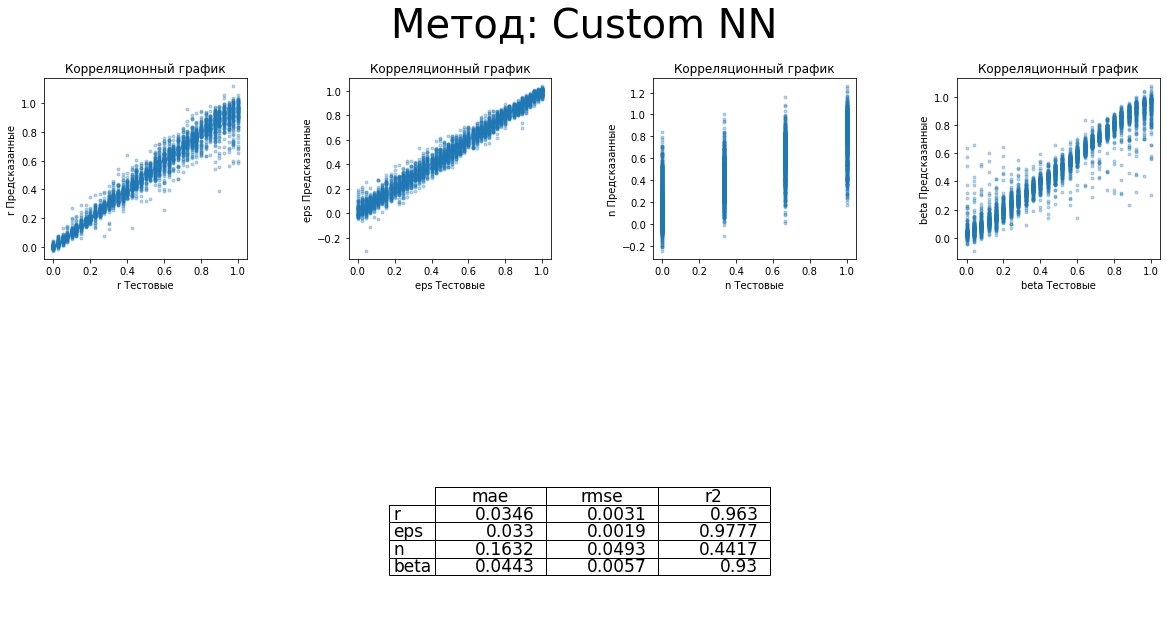

In [30]:
regr_model_resume(Y_test_scaled, Y_predict_scaled,method='Custom NN')

In [16]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('epochs', fontsize=15)
plt.legend(fontsize=20)
plt.show()

plt.plot(history.history['mae'], label='train mae')
plt.plot(history.history['val_mae'], label='val mae')
plt.xlabel('epochs', fontsize=15)
plt.legend(fontsize=20)
plt.show()

plt.plot(history.history['mape'], label='train mape')
plt.plot(history.history['val_mape'], label='val mape')
plt.xlabel('epochs', fontsize=15)
plt.legend(fontsize=20)
plt.show()

plt.plot(history.history['cosine_proximity'], label='train cosine_proximity')
plt.plot(history.history['val_cosine_proximity'], label='val cosine_proximity')
plt.xlabel('epochs', fontsize=15)
plt.legend(fontsize=20)
plt.show()

NameError: name 'history' is not defined

In [ ]:
import timeit
start_time = timeit.default_timer()
preds = model.predict(X_test)
time_1 = timeit.default_timer() - start_time
print("Общее время: " + str(time_1) + " мс")
print("Время на частицу: " + str(time_1/len(X_test)*1000) + " мс")

1533/1533 [==============================] - 3s 2ms/step
Общее время: 5.2027305739998155 мс
Время на частицу: 0.10610022379475927 мс
